### TO-DO LIST

* <strike>Manually draw the line of the frame</strike>
* <strike>Add date and time</strike>
* <strike>Create a df for each user ID with their exact location</strike>
* <strike>Create a df with # of entries and exists</strike>
* <strike>Find the time each ID appeared and disappeared in the frame, and include in user dataset</strike>
* <strike>Modify place df to include # of objects inside, and their centriods at a given time</strike>
* <strike>Motion Heatmaps</strike>
* <strike>Try to do social distancing w.r.t. objectID instead of index in a frame</strike>
* <strike>Create violation dataset with objectIDs, duration, and location</strike>
* <strike>Create a function to show the last n violations</strike>
* <strike>Bird View (top view)</strike>
* Generate some insights
* Interactive plots/Dash: heatmap at a given time/s, flow for a given user/s, and the other normal plots (duration, entries, exits, etc ..)
* <strike>For more accurate counting, modify for inclined lines once object touches line coordinates (instead of endlines)</strike>
* <strike>Try on YOLO along with MobileNet SSD</strike>
* Try to split into regions + insights for each
* Try with more powerful tracking algorithm (i.e. Kalman Filter, Deep SORT, ..)
* Try image segmentation

------------------

## People Counter + Social Distancing Code Implementation

#### Imports + Input Variables

In [1]:
# imports

from classes.centroidtracker_TimeRect import CentroidTracker
from classes.trackableobject import TrackableObject

import numpy as np
import pandas as pd
import time
import datetime
from datetime import datetime as dt
import matplotlib.pyplot as plt

import copy

from numpy import ones, vstack
from numpy.linalg import lstsq


import cv2
import dlib

# calculate estimated frame/sec
import imutils
from imutils.video import VideoStream
from imutils.video import FPS # calculate estimated frame/sec

import os

from scipy.spatial import distance 
import math

In [2]:
video_name = 'TownCentreXVID.avi'
video_path = os.path.join('videos',video_name)

### Manually Draw Gate Line

In [3]:
def manual_draw(event,x,y,flags,param):
    
    '''
    Draws the gate line manually to detect entries and exists
    Returns the frame, endpoints of the line, and boolean
    defining horizantal or vertical
    '''
    
    # Here is where global functions are updated
    global pt1,pt2,StartPoint_clicked,EndPoint_clicked

    # get left mouse is clicked (down)
    if event == cv2.EVENT_LBUTTONDOWN:
        
        # RESET THE RECTANGLE IF DRAWN
        if StartPoint_clicked == True and EndPoint_clicked == True:
            StartPoint_clicked = False
            EndPoint_clicked = False
            pt1 = (0,0)
            pt2 = (0,0)

        if StartPoint_clicked == False:
            pt1 = (x,y)
            StartPoint_clicked = True
            
        elif EndPoint_clicked == False:
            pt2 = (x,y)
            EndPoint_clicked = True

        
# GLOBAL VARIABLES
pt1 = (0,0) #top left
pt2 = (0,0) #bottum right
StartPoint_clicked = False
EndPoint_clicked = False


# CONNECT TO THE CALLBACK
cap = cv2.VideoCapture(video_path) 

# Create a named window for connections
cv2.namedWindow('DrawLine')

# Bind draw_rectangle function to mouse cliks
cv2.setMouseCallback('DrawLine', manual_draw) 


while True:
    # Capture frame-by-frame
    res, frame = cap.read()
    
    if not res:
        break
        
    # Resize and convert the frame into RGB
    frame = imutils.resize(frame, width=500)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Create circle on the first point you click
    if StartPoint_clicked:
        cv2.circle(frame, center=pt1, radius=2, color=(0,255,255), thickness=-1)
        
    if StartPoint_clicked and EndPoint_clicked:
        cv2.line(frame, pt1, pt2, (0, 255, 255), 3)

        
    # Display the resulting frame
    cv2.imshow('DrawLine', frame)
    
    # save the points of the line
    np.save('line_points.npy', [pt1, pt2])

    
    # This command let's us quit with the ESC button on a keyboard.
    if cv2.waitKey(1) & 0xFF==27:
        break
        
        
# When everything is done, release the capture
cap.release()
cv2.destroyAllWindows()

In [6]:
print('startpoint:', pt1, 'endpoint:', pt2)

startpoint: (96, 87) endpoint: (473, 176)


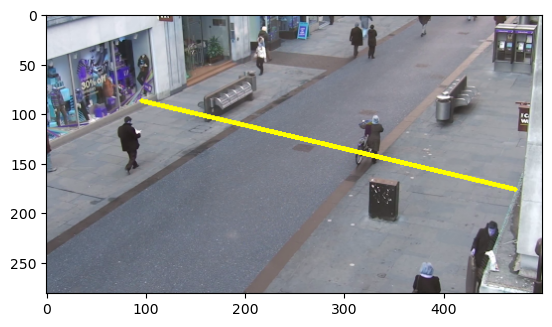

In [7]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)

### Get Line Orientation + Equation + Counting

In [4]:
def line_orientation(frame,startLine,endLine):
    
    cv2.line(frame, startLine, endLine, (255,0,0),2)
        
    if abs(startLine[0]-endLine[0]) < 10:
        orientation = 'Perfect_Horizantal' 
    elif abs(startLine[1]-endLine[1]) < 10:
        orientation = 'Perfect_Vertical'
    
    elif abs(startLine[0]-endLine[0]) > abs(startLine[1]-endLine[1]):
        orientation = 'Horizantal'
    else:
        orientation = 'Vertical' 
        
    return orientation

In [5]:
def f(x,startLine,endLine):
    # from numpy import ones,vstack
    # from numpy.linalg import lstsq
    
    points = [startLine,endLine]
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords,ones(len(x_coords))]).T
    m, b = lstsq(A, y_coords,rcond=None)[0]
    
    y = m*x+b
    
    return y

In [6]:
def counting(frame,to,centroid,objectID,startLine,endLine,Enter,Exit):
    
    orientation = line_orientation(frame,startLine,endLine)

    if orientation == 'Perfect_Horizantal':

        # Difference between y-cor. of the 'current' centroid
        # and the mean of 'previous' centroids
        # -ve for 'up', +ve for 'down'
        y = [c[1] for c in to.centroids]
        direction = centroid[1] - np.mean(y)
        to.centroids.append(centroid)

        # Check if object has been counted or not
        # if direction<0 and centriod above line
        if not to.counted:
            if direction <0 and centroid[1] < startLine[1]:
                Enter+=1
                to.counted = True

            elif direction>0 and centroid[1]> startLine[1]:
                Exit+=1
                to.counted = True

    if orientation == 'Perfect_Vertical':
        # -ve for 'left', +ve for 'right'
        x = [c[0] for c in to.centroids]
        direction = centroid[0] - np.mean(x)
        to.centroids.append(centroid)

        # Check if object has been counted or not
        # if direction<0 and centriod above line
        if not to.counted:
            if direction <0 and centroid[0] > startLine[0]:
                Enter+=1
                to.counted = True  

            elif direction>0 and centroid[0] < startLine[0]:
                Exit+=1
                to.counted = True
                
    
    if orientation == 'Horizantal':
        # -ve for 'up', +ve for 'down'
        y = [c[1] for c in to.centroids]
        direction = centroid[1] - np.mean(y)
        to.centroids.append(centroid)


        # Check if object has been counted or not
        # if direction<0 and centriod above line
        # at least one value of y should be below the line to validated entry
        if not to.counted:
            if direction<0 and centroid[1] < f(centroid[0],startLine,endLine) and len([i for i in y if i > f(centroid[0],startLine,endLine)]) > 0:
                Enter+=1
                to.counted = True

            elif direction>0 and centroid[1] > f(centroid[0],startLine,endLine) and len([i for i in y if i < f(centroid[0],startLine,endLine)]) > 0:
                Exit+=1
                to.counted = True

    if orientation == 'Vertical':
        # -ve for 'up', +ve for 'down'
        x = [c[0] for c in to.centroids]
        direction = centroid[0] - np.mean(x)
        to.centroids.append(centroid)
                                                 
        # x<0 -> direction<0 and object walking left
        if not to.counted:
            if direction<0 and centroid[0] > f(centroid[1],startLine,endLine) and len([i for i in y if i > f(centroid[1],startLine,endLine)]) > 0:
                Enter+=1
                to.counted = True

            elif direction>0 and centroid[0] < f(centroid[1],startLine,endLine) and len([i for i in y if i > f(centroid[1],startLine,endLine)]) > 0:
                Exit+=1
                to.counted = True
                
    return Enter, Exit

---------------------

### Social Violation Function

In [7]:
def social_violated(centroid_list,minSocialDistance, objectID_list):
    # Calculate the Euclidean distance between
    # each centroids in a given frame
    
    '''
    Returns the indices of centroid violated per frame
    '''

    distance_matrix = distance.cdist(centroid_list, centroid_list, metric="euclidean")


    # Find indices (centroids) violating social
    # Distancing criteria
    # (ind1,ind2) means object #ind1 and object #ind2 are violating   
    violated = [(ind1,ind2) for ind1,row in enumerate(distance_matrix) 
                for ind2,col in enumerate(row) 
                if col<minSocialDistance and col>0 and ind1!=ind2]

    # Remove repeated items
    # (a,b) & (b,a) are the same thing
    vio = set()  
    temp = [vio.add((a, b)) for (a, b) in violated  
            if (a, b) and (b, a) not in vio]

    # List of tuples of violated indx in a given frame
    vio = list(vio)
    
    # Based on ObjectID
    vio_ID = [(objectID_list[i],objectID_list[j]) for (i,j) in vio]
    
    # Convert to a list of indices (then delete duplicate)
    vio_ind_list = [item for i in vio for item in i] 
    vio_ind_list = list(dict.fromkeys(vio_ind_list))

    
    vio_time = dt.now()
    
    return vio, vio_ID, vio_time, vio_ind_list

-------------

## Bird View Function

In [8]:
def BirdView(background, centroid_list, vio):
    for k,centroid in enumerate(centroid_list):
        cv2.circle(background, (centroid[0], centroid[1]), 10, (0, 255, 0), 1)
        cv2.circle(background, (centroid[0], centroid[1]), 2, (0, 255, 0), -1)
        for j in vio:
            if k==j[1]:
                # Red circles for violations
                cv2.circle(background, (centroid[0], centroid[1]), 10, (0,0,255), 1) 
                cv2.circle(background, (centroid[0], centroid[1]), 2, (0, 0, 255), -1)
                
            if k==j[0]:
                cv2.circle(background, (centroid[0], centroid[1]), 10, (0,0,255), 1) 
                cv2.circle(background, (centroid[0], centroid[1]), 2, (0, 0, 255), -1)
            cv2.line(background, centroid_list[j[0]], centroid_list[j[1]], (0, 0, 255), 4)
            
    return background

## Heatmap
https://towardsdatascience.com/build-a-motion-heatmap-videousing-opencv-with-python-fd806e8a2340

In [9]:
def motion_heatmap(frame,Frames,thres_heat,maxValue,accum_image,first_frame):
    import copy
    
    # If first frame
    if Frames == 0:

        first_frame = copy.deepcopy(frame)
        accum_image = np.zeros(frame.shape[:2], np.uint8)
        heat_frame = np.zeros(frame.shape[:2], np.uint8)
                
    
    else:

        subtractor = background_subtractor.apply(frame)  
        cv2.imwrite('heatmap/frame.jpg', frame)
        cv2.imwrite('heatmap/diff-bkgnd-frame.jpg', subtractor)

        threshold = thres_heat
        maxValue = maxValue
        ret, th1 = cv2.threshold(subtractor, threshold, maxValue, cv2.THRESH_BINARY)
        

        # add to the accumulated image
        accum_image = cv2.add(accum_image, th1)
        #cv2.imwrite('heatmap/heatmap_mask.jpg', accum_image)

        color_image_video = cv2.applyColorMap(accum_image, cv2.COLORMAP_JET)

        heat_frame = cv2.addWeighted(frame, 0.7, color_image_video, 0.7, 0)
        
        
    return heat_frame, accum_image, first_frame

---------------------------

# Social Distancing Detector


**NOTE:** The whole code is here, but the funtion is at the end

In [10]:
# load the YOLO model

weightsPath = "yolo-coco/yolov3.weights"
configPath = "yolo-coco/yolov3.cfg"

net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

In [11]:
out_path = os.path.join("output", 'social_distance.avi')
out_path_bird = os.path.join('output','birdview.avi')

In [12]:
video = cv2.VideoCapture(video_path)
cv2.namedWindow("count", cv2.WINDOW_AUTOSIZE)


#========================#
# Inputs

# Initiate input varaibles
maxDisappeared=7
maxDistance=7
skipframes=20
thres=0.3
minSocialDistance=20

# how frequent you need to update the df
place_seconds = 0  # 0 if you want to skip
user_seconds = 0

# Initiate the YOLO Model
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]
nms_thres = 0.3
thres=0.3

# Heatmap Variables
thres_heat = 2
maxValue = 2
out_path_heat = 'heatmap/heatmap.avi'
background_subtractor = cv2.bgsegm.createBackgroundSubtractorMOG()
length = int(video.get(cv2.CAP_PROP_FRAME_COUNT)) # number of frames


#======================#
# Outputs
frame_list = []
background_list = []
heat_frame_list = []

# Initiate output lists for df
# places
place_time_lst = []
entries_lst = []
exits_lst = []

place_objectID = [] # To get the objectID and Centroids at each instant
place_centroids = []

#users
user_time_lst = []

# list of tuples of objectID with centroid
objects_list = []


# vio df variables
vio_ID_list = []
vio_time_list = []
vio_frame_list = [] # frame itself
vio_fnum_list = [] # frame number
vio_numobj_list = [] # number of objects
vio_numvio_list = [] # number of violations


# Define start and end points of crossing line
# from the line drawn manually in 'manual_draw'
startLine = pt1
endLine = pt2


# Initiate the total # of frames, and entries and exists
Enter = 0
Exit = 0
Frames = 0

# Initialize writer
writer = None


# Initiate the CentriodTracker
ct = CentroidTracker(maxDisappeared, maxDistance=50)

# Initiate list to store dlib correlation tracker
trackers = []

# Initiate a dict to map each unique ID to Trackableoject
trackableObjects = {}

# Start the f/s estimator
fps = FPS().start()


# while we read the video
while True:
    
#     print('----------------')
#     print('frame:', Frames)
    
    res, frame = video.read()
    res2, frame2 = video.read() # for the heatmap
    
    if not res or not res2:
        break

    # Resize and convert the frame into RGB
    frame = imutils.resize(frame, width=500)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    frame2 = imutils.resize(frame2, width=500)

    
    # Set the dimentions of the frame H & W
    H = frame.shape[0]
    W = frame.shape[1]
    
    # Define Background for the BirdView - ONLY during first frame to save memory
    background = np.zeros((H, W), np.uint8)
    background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)


    # Define Writers
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter(out_path, fourcc, 30,
                                 (W, H), True)
        writer_bird = cv2.VideoWriter(out_path_bird, fourcc, 30,
                                 (W, H), True)
        writer_heat = cv2.VideoWriter(out_path_heat, fourcc, 30,
                                 (W, H), True)

        
    # Initialize status & list of bounding boxes
    status = 'Waiting'
    rects = []

        #  Initializtion for the heatmap
    if Frames==0:
        first_frame = copy.deepcopy(frame)
        accum_image = np.zeros(frame.shape[:2], np.uint8)


    #====================================================#
    # If: we utilize object "detection" for skipped-based frames
    #====================================================#       

    # Check if we skip frames to avoid computational complexity
    if Frames % skipframes == 0:
        status = 'Detecting'
        trackers = []

    #====================================================#
    # Deep Learning Detection
    #====================================================#
    
    # determine only the *output* layer names that we need from YOLO
        blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)        
        net.setInput(blob)
        layerOutputs = net.forward(ln)
        
        boxes=[]
        confidences=[]
        classIDs=[]
        
        
        for output in layerOutputs:
            for detection in output:
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]
                
                # filter person  > Class ID = 0
                if confidence > thres  and classID == 0:
                    box = detection[0:4] * np.array([W, H, W, H])
                    (centerX, centerY, width, height) = box.astype("int")
                    # Top and Left corner of box
                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))
                    boxes.append([x, y, int(width), int(height)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)

        idxs = cv2.dnn.NMSBoxes(boxes, confidences, 
                                thres, nms_thres)
        # Ensure at least one detection
        if len(idxs) > 0:
            # loop over the indexes we are keeping
            for i in idxs.flatten():
                # extract the bounding box coordinates
                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])
                
                # Instantiate dlib correlation tracker
                tracker = dlib.correlation_tracker()
                # Find object's bounding box
                rect = dlib.rectangle(x, y, x+w, y+h)
                # Start tracking
                tracker.start_track(frame, rect)
                # Append trackers
                trackers.append(tracker)
                
                rects.append((x,y,x+w,y+h))
                
                cv2.rectangle(frame, (x, y), (x+w, y+h), 
                              (0,255,0), 1)
                

    #====================================================#
    # Else: we utilize object "tracker" rather than detector
    # To obtain a higher frame processing throughput
    #====================================================#
    else:

        for tracker in trackers:
            status = 'Tracking'

            # Update the tacker and grab update position
            tracker.update(frame)
            pos = tracker.get_position()

            # Unpack the object's position
            startX = int(pos.left())
            startY = int(pos.top())
            endX = int(pos.right())
            endY = int(pos.bottom())

            # Append the rects with the new bounding box coordinates
            rects.append((startX, startY, endX, endY))

           # Draw Rectangle 
            cv2.rectangle(frame, (startX, startY), (endX, endY),
                          (0,255,0), 1)
            

    #====================================================#
    # Update Centriod Tracker with newly computed centriod
    #====================================================#
    objects = ct.update(rects)
    
    # Retrieve the dictionaries of the start and end time of each ID
    startID = ct.start_date()
    endID = ct.end_date()
    
    #====================================================#
    # Count Entries and Exits, write ID, and draw circle
    #====================================================#        

    # Loop over the tracked objects

    for (objectID, (centroid,rect)) in objects.items():

        # check to see if a trackable object exists for the current ID
        to = trackableObjects.get(objectID, None)
        # if there is no existing trackable object, create one
        if to is None:
            to = TrackableObject(objectID, centroid)

        # Otherwise, there is trackable object we utilize it to determine
        # Direction
        else:

            Enter, Exit = counting(frame,to,centroid,objectID,startLine,endLine,Enter,Exit)
                      

        # store the trackable object in our dictionary            
        trackableObjects[objectID] = to

        # draw both the ID of the object and the centroid of the
        # object on the output frame
        text = "ID:{}".format(objectID)
        cv2.putText(frame, text, (centroid[0] - 10, centroid[1] - 10),
                    cv2.FONT_HERSHEY_PLAIN, 1, (0, 255, 255), 1)
        cv2.circle(frame, (centroid[0], centroid[1]), 2, (0, 255, 255), -1)

    
    #====================================================#
    # LOOPING OVER OBJECTS IN A FRAME
    #====================================================#
    rect_list = []
    objectID_list = []
    centroid_list = []

    for (objectID, (centroid,rect)) in objects.items():
        
        # Provide a list of each objectIDs in a given frame
        objectID_list.append(objectID)
        # List of centroid locations shown in a given frame
        centroid_list.append(tuple(centroid))
        # List of centroid locations shown in a given frame
        rect_list.append(rect)
        
#     print(rect_list)
#     print(centroid_list)
#     print(objectID_list)
    

    #====================================================#
    # Social Distancing Detector - outside loop
    #====================================================#   
                
    # Ensure at least 2 objects are there in the frame
    if len(objects)>=2:
        # List of tuples contains indices of violating centroids in a given frame
        vio, vio_ID, vio_time, vio_ind_list = social_violated(centroid_list,minSocialDistance,objectID_list)


         # Get the rects corresponding to the violated indx
        for k,rect in enumerate(rect_list):
            for j in vio:
                if k==j[1] or k==j[0]:
                    startX=rect[0]
                    startY=rect[1]
                    endX=rect[2]
                    endY=rect[3]

                    # Red rects for violations
                    cv2.rectangle(frame, (startX, startY), (endX, endY), (0,0,255), 2)    
      
                    
    #====================================================#
    # Violation DataFrame
    #====================================================#     

        # List is updated each frame
        if vio_ID != []:
            vio_ID_list.append(vio_ID)
            vio_time_list.append(vio_time)
            vio_fnum_list.append(Frames)
            vio_numobj_list.append(len(objects))
            vio_numvio_list.append(len(vio_ind_list))
            

    
    #====================================================#
    # BirdView
    #====================================================#                     
    
    birdview = BirdView(background,centroid_list,vio)  

    #====================================================#
    # HeatMap function call
    #====================================================# 
    
    heat_frame, accum_image, first_frame = motion_heatmap(frame2,Frames,thres_heat,maxValue,accum_image,first_frame)
        
    #====================================================#
    # Information to be displayed on the frame
    #====================================================# 
    info = [
        ("Time",dt.now()),
        ("Enter", Enter),
        ("Exit", Exit),
        ("Status", status)]


    # loop over the info tuples and draw them on our frame
    for (i, (k, v)) in enumerate(info):
        text = "{}: {}".format(k, v)
        cv2.putText(frame, text, (7, H - ((i * 12) + 12)),
            cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1)



    #====================================================#
    # Preparing the places dataframe
    #====================================================# 

    # We need to do update the dataframe for every 10 seconds
    place_multiplier = place_seconds*video.get(cv2.CAP_PROP_FPS)
    
    # If you don't want to skip
    if place_seconds == 0:
        place_multiplier = 1

    if Frames % place_multiplier == 0:
        place_time_lst.append(dt.now())
        entries_lst.append(Enter)
        exits_lst.append(Exit)
        
        
        place_objectID.append(objectID_list)
        place_centroids.append(centroid_list)
        
        
    #====================================================#
    # Preparing the users dataframe
    #====================================================#    
    
    user_multiplier = user_seconds*video.get(cv2.CAP_PROP_FPS)
    
    if user_seconds == 0:
        user_multiplier = 1
    
    # This will append all objects for all frames
    if Frames % user_multiplier == 0:
        for (objectID, (centroid,rect)) in objects.items():
            objects_list.append((objectID, centroid))

            
    #====================================================#
    # Save Frames/Images
    #====================================================#
    
    # SUGGESTION: for longer footage do it while skipping some frames
    frame_list.append(frame)
    background_list.append(background)
    heat_frame_list.append(heat_frame)
    
    #====================================================#
    # Window name and exit condition
    #====================================================#
    writer.write(frame)
    writer_bird.write(birdview)
    writer_heat.write(heat_frame)

    # show the output frame
    cv2.imshow("count", frame)
    cv2.imshow('birdview',birdview)
    cv2.imshow('heatmap',heat_frame)
    
    

    # if the `q` key was pressed, break from the loop
    if cv2.waitKey(1) & 0xFF==27:
        break

    # increment the total number of frames processed thus far and
    # then update the FPS counter
    Frames += 1
    fps.update()

    
#====================================================#
# HeatMap final calculations
#====================================================#    
    
color_image = cv2.applyColorMap(accum_image, cv2.COLORMAP_JET)
result_overlay = cv2.addWeighted(first_frame, 0.7, color_image, 0.7, 0)

# save the final heatmap
cv2.imwrite('heatmap/final_heatmap.jpg', result_overlay)
    
    
# stop the timer and display FPS information
fps.stop()

print("[INFO] elapsed time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))
print("[INFO] Total Frames: {:.2f}".format(Frames))



# check to see if we need to release the video writer pointer
writer.release()
writer_bird.release()
writer_heat.release()
video.release()
cv2.destroyAllWindows()

2023-07-24 09:46:07.155 python[42295:3053391] Warning: Window move completed without beginning


[INFO] elapsed time: 327.51
[INFO] approx. FPS: 3.54
[INFO] Total Frames: 1160.00


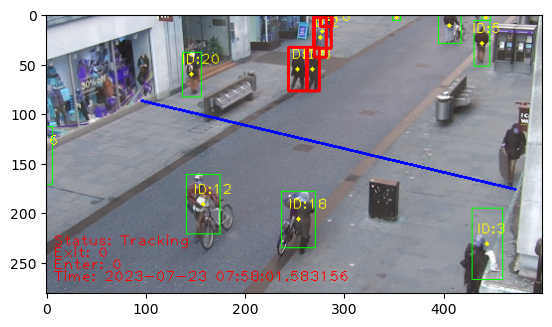

In [17]:
# This shows the last frame
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)

-----------------------

## Creating DataFrames

#### Places DataFrame

Measurements taken every **5 seconds**


In [16]:
len(place_time_lst)

36

In [17]:
len(exits_lst)

36

In [18]:
len(place_objectID)

36

In [19]:
# Creating the dataframe 
import pandas as pd

placeID = 1
capacity = 300

df_place = pd.DataFrame({'placeID':placeID,
             'Capacity':capacity,
             'Time':place_time_lst,
             'Entries':entries_lst,
             'Exits':exits_lst})

In [20]:
df_place['Remaining'] = df_place.Capacity - (df_place.Entries-df_place.Exits)

In [21]:
df_place['ObjectID'] = np.array(place_objectID)
df_place['NumObjects'] = df_place.ObjectID.apply(len)
df_place['Centroid'] = np.array(place_centroids)

/var/folders/rv/bq7n0p4d5ys5hkcc1xgr7gy00000gn/T/ipykernel_36473/3892613372.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_place['ObjectID'] = np.array(place_objectID)
/var/folders/rv/bq7n0p4d5ys5hkcc1xgr7gy00000gn/T/ipykernel_36473/3892613372.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_place['Centroid'] = np.array(place_centroids)


In [22]:
df_place

,placeID,Capacity,Time,Entries,Exits,Remaining,ObjectID,NumObjects,Centroid
0,1,300,2023-07-22 12:45:04.776012,0,0,300,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",18,"[(81, 242), (236, 39), (432, 191), (388, 28), ..."
1,1,300,2023-07-22 12:45:05.089844,0,0,300,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",18,"[(77, 244), (237, 39), (431, 191), (389, 27), ..."
2,1,300,2023-07-22 12:45:05.413159,0,0,300,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",18,"[(73, 246), (238, 37), (432, 193), (389, 27), ..."
3,1,300,2023-07-22 12:45:05.664737,0,0,300,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",18,"[(70, 250), (239, 36), (433, 195), (390, 26), ..."
4,1,300,2023-07-22 12:45:05.893242,0,0,300,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",18,"[(67, 255), (240, 37), (433, 198), (391, 26), ..."
5,1,300,2023-07-22 12:45:06.117735,0,0,300,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",18,"[(63, 258), (241, 37), (434, 201), (391, 25), ..."
6,1,300,2023-07-22 12:45:06.337863,0,0,300,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",18,"[(59, 260), (242, 37), (436, 203), (391, 24), ..."
7,1,300,2023-07-22 12:45:06.593623,0,0,300,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",18,"[(56, 262), (244, 36), (436, 205), (392, 24), ..."
8,1,300,2023-07-22 12:45:06.827138,0,0,300,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",18,"[(51, 265), (245, 36), (436, 207), (392, 24), ..."
9,1,300,2023-07-22 12:45:07.079808,0,0,300,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",18,"[(48, 270), (247, 35), (437, 209), (393, 24), ..."


#### Users DataFrame

In [23]:
ids = [i[0] for i in objects_list]
cnts = [tuple(i[1]) for i in objects_list]
objects_list = tuple(zip(ids,cnts))
# sort by ID
objects_list = sorted(objects_list, key=lambda x:x[0])
objects_list[:5]

[(1, (81, 242)),
 (1, (77, 244)),
 (1, (73, 246)),
 (1, (70, 250)),
 (1, (67, 255))]

In [24]:
# Transform to dict for each ID
objects_dict = {}
for i in objects_list:  
    objects_dict.setdefault(i[0],[]).append(i[1])

In [18]:
startID


OrderedDict([(1, datetime.datetime(2023, 7, 23, 7, 57, 53, 53622)),
             (2, datetime.datetime(2023, 7, 23, 7, 57, 53, 53634)),
             (3, datetime.datetime(2023, 7, 23, 7, 57, 53, 53637)),
             (4, datetime.datetime(2023, 7, 23, 7, 57, 53, 53639)),
             (5, datetime.datetime(2023, 7, 23, 7, 57, 53, 53642)),
             (6, datetime.datetime(2023, 7, 23, 7, 57, 53, 53648)),
             (7, datetime.datetime(2023, 7, 23, 7, 57, 53, 53650)),
             (8, datetime.datetime(2023, 7, 23, 7, 57, 53, 53652)),
             (9, datetime.datetime(2023, 7, 23, 7, 57, 53, 53654)),
             (10, datetime.datetime(2023, 7, 23, 7, 57, 53, 53656)),
             (11, datetime.datetime(2023, 7, 23, 7, 57, 53, 53660)),
             (12, datetime.datetime(2023, 7, 23, 7, 57, 53, 53663)),
             (13, datetime.datetime(2023, 7, 23, 7, 57, 53, 53665)),
             (14, datetime.datetime(2023, 7, 23, 7, 57, 53, 53667)),
             (15, datetime.datetime(2023, 7

In [25]:
df_users = pd.DataFrame(objects_dict.items())

df_users.columns = ['UserID','Coordinates']

df_users['StartTime'] = df_users.UserID.map(startID)
df_users['EndTime'] = df_users.UserID.map(endID)
df_users['Duration'] = df_users.EndTime - df_users.StartTime

In [26]:
df_users

,UserID,Coordinates,StartTime,EndTime,Duration
0,1,"[(81, 242), (77, 244), (73, 246), (70, 250), (...",2023-07-22 12:45:04.774773,2023-07-22 12:45:11.467734,0 days 00:00:06.692961
1,2,"[(236, 39), (237, 39), (238, 37), (239, 36), (...",2023-07-22 12:45:04.774785,NaT,NaT
2,3,"[(432, 191), (431, 191), (432, 193), (433, 195...",2023-07-22 12:45:04.774788,NaT,NaT
3,4,"[(388, 28), (389, 27), (389, 27), (390, 26), (...",2023-07-22 12:45:04.774790,NaT,NaT
4,5,"[(438, 50), (437, 50), (437, 49), (437, 49), (...",2023-07-22 12:45:04.774793,NaT,NaT
5,6,"[(84, 101), (81, 102), (78, 102), (74, 105), (...",2023-07-22 12:45:04.774796,NaT,NaT
6,7,"[(358, 18), (360, 17), (361, 16), (363, 15), (...",2023-07-22 12:45:04.774799,2023-07-22 12:45:11.467744,0 days 00:00:06.692945
7,8,"[(215, 87), (216, 85), (218, 85), (219, 84), (...",2023-07-22 12:45:04.774801,NaT,NaT
8,9,"[(262, 15), (262, 15), (263, 15), (264, 15), (...",2023-07-22 12:45:04.774803,NaT,NaT
9,10,"[(305, 9), (304, 8), (304, 9), (304, 9), (304,...",2023-07-22 12:45:04.774806,NaT,NaT


-----------------------

### Violation DataFrame

In [27]:
vio_df = pd.DataFrame({'time':vio_time_list,
                   'ids':vio_ID_list,
                   'frame':vio_fnum_list,
                  'obj_num':vio_numobj_list,
                  'vio_num':vio_numvio_list})

vio_df['vio_ratio'] = (vio_df.vio_num / vio_df.obj_num)*100
vio_df

,time,ids,frame,obj_num,vio_num,vio_ratio
0,2023-07-22 12:45:04.775282,"[(9, 16), (8, 11), (7, 15), (10, 17)]",0,18,8,44.444444
1,2023-07-22 12:45:05.066772,"[(9, 16), (8, 11), (7, 15), (10, 17)]",1,18,8,44.444444
2,2023-07-22 12:45:05.401929,"[(9, 16), (8, 11), (7, 15), (10, 17)]",2,18,8,44.444444
3,2023-07-22 12:45:05.654769,"[(9, 16), (8, 11), (7, 15)]",3,18,6,33.333333
4,2023-07-22 12:45:05.884127,"[(8, 11), (9, 16)]",4,18,4,22.222222
5,2023-07-22 12:45:06.108492,"[(8, 11), (9, 16)]",5,18,4,22.222222
6,2023-07-22 12:45:06.328955,"[(9, 16)]",6,18,2,11.111111
7,2023-07-22 12:45:06.584532,"[(8, 11), (9, 16)]",7,18,4,22.222222
8,2023-07-22 12:45:06.817571,"[(8, 11), (9, 16)]",8,18,4,22.222222
9,2023-07-22 12:45:07.070273,"[(8, 11), (9, 16)]",9,18,4,22.222222


In [28]:
# Unstack multi-valued ID and repeat other columns accordingly
# each ID row should only correspond to one pair
ids = [j for i in vio_df.ids for j in i]
df = pd.DataFrame({col:np.repeat(vio_df[col].values, vio_df['ids'].str.len()) for col in vio_df.columns.drop(['ids',
                                                                                                      'obj_num',
                                                                                                      'vio_num',
                                                                                                      'vio_ratio'])})
# insert 'ids' first
df.insert(loc=0, column='ids', value=ids)

In [29]:
# create summary df
df_vio_summary = df.drop_duplicates('ids',keep='first').reset_index().drop('index',axis=1)
df_vio_summary.columns = ['ids','start_time','start_frame']

Get the last index - from the violated list - that corresponds to each pair
From that we can extract the ending values for time and frame

In [30]:
last_ind = {}
for i in set(ids):
    res = max(idx for idx, val in enumerate(ids)  
                                    if val == i)
    last_ind[i]=res

In [31]:
df_vio_summary['end_index'] = df_vio_summary.ids.map(last_ind)

df_vio_summary['end_time'] = df_vio_summary.end_index.apply(lambda x: df.time[x])
df_vio_summary['end_frame'] = df_vio_summary.end_index.apply(lambda x: df.frame[x])

df_vio_summary['duration'] = df_vio_summary.end_time - df_vio_summary.start_time

df_vio_summary

,ids,start_time,start_frame,end_index,end_time,end_frame,duration
0,"(9, 16)",2023-07-22 12:45:04.775282,0,85,2023-07-22 12:45:11.284220,26,0 days 00:00:06.508938
1,"(8, 11)",2023-07-22 12:45:04.775282,0,110,2023-07-22 12:45:13.105429,35,0 days 00:00:08.330147
2,"(7, 15)",2023-07-22 12:45:04.775282,0,14,2023-07-22 12:45:05.654769,3,0 days 00:00:00.879487
3,"(10, 17)",2023-07-22 12:45:04.775282,0,11,2023-07-22 12:45:05.401929,2,0 days 00:00:00.626647
4,"(4, 7)",2023-07-22 12:45:08.047580,13,84,2023-07-22 12:45:11.284220,26,0 days 00:00:03.236640
5,"(10, 16)",2023-07-22 12:45:09.473967,19,82,2023-07-22 12:45:11.284220,26,0 days 00:00:01.810253
6,"(9, 10)",2023-07-22 12:45:09.473967,19,109,2023-07-22 12:45:13.105429,35,0 days 00:00:03.631462
7,"(2, 10)",2023-07-22 12:45:11.884477,29,108,2023-07-22 12:45:13.105429,35,0 days 00:00:01.220952


#### Preview Last N Violated Frames

In [32]:
# Convert colors - Do it once!

def convert_color(frame_list):
    for i,j in enumerate(frame_list):
        frame_list[i] = cv2.cvtColor(frame_list[i], cv2.COLOR_BGR2RGB)
    
    return frame_list

In [33]:
frame_list = convert_color(frame_list)

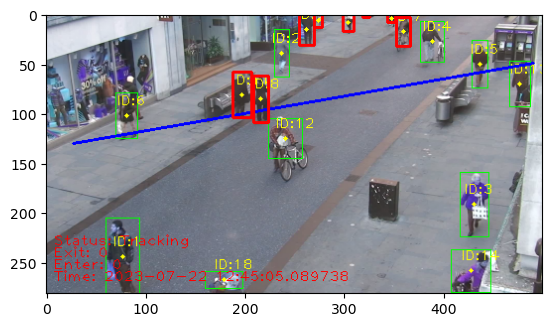

In [34]:
plt.imshow(frame_list[1])

In [35]:
n = 10

In [36]:
vio_fnum_list[-n:]

[26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

In [47]:
def last_n_violations(n,frame_list,vio_fnum_list):    
    
    nrows = int(np.ceil(10/3))
    ncols = 3
    
    # Define subplots
    plt.figure(figsize=(15,15), dpi=80)
    plt.grid('off')
    plt.suptitle('Last %s violated frames'%n)
    
    # Find last n violated frame numbers
    violated_nframes = vio_fnum_list[-n:]

    for i,v in enumerate(violated_nframes):
        plt.subplot(nrows,ncols,i+1)
        plt.imshow(frame_list[v])

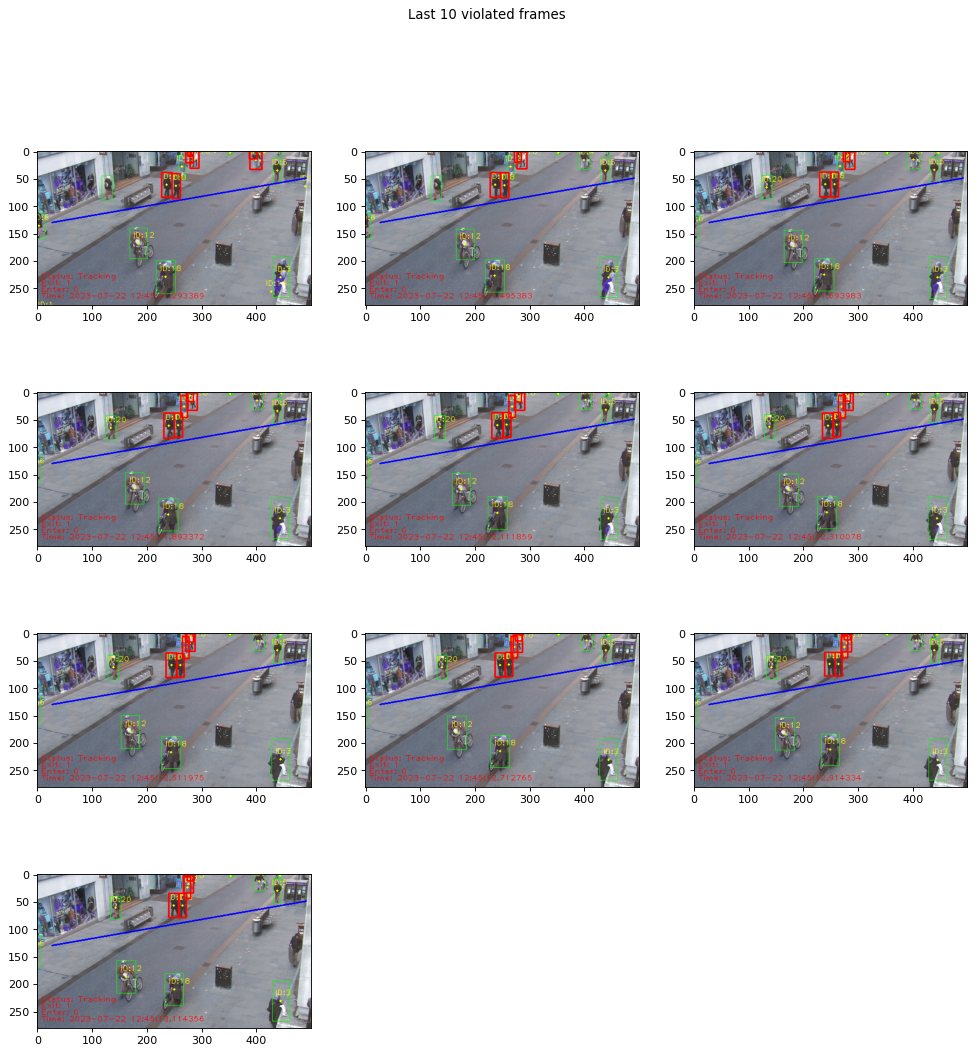

In [48]:
last_n_violations(n,frame_list,vio_fnum_list)